# Movie Revenue Prediction 
The requirements.txt file includes every pip install and dataset needed to run the code.

The dataset includes ~1,274,092 movies which icludes blockbusters like "The GodFather" and "Spider-Man: Across the Spider-Verse". The dataset includes 24 potential features to choose from. The total CSV memory is ~500mb.

In [59]:
import pandas as pd
# Read the CSV into df
df = pd.read_csv("C:/Users/homec/Downloads/TMDB_movie_dataset_v11.csv")

#Print first row
print("Potential Features:", ", ".join(df.columns))

Potential Features: id, title, vote_average, vote_count, status, release_date, revenue, runtime, adult, backdrop_path, budget, homepage, imdb_id, original_language, original_title, overview, popularity, poster_path, tagline, genres, production_companies, production_countries, spoken_languages, keywords


##### Many of the potential features like "tagline, adult, and homepage" won't impact the results so we need to pick out our features. Filters to the features were needed to remove non-released movies.

In [60]:
df = df[~(
    (df['vote_average'] == 0) |
    (df['vote_count'] <= 50) |
    (df['runtime'] <= 60) |
    (df['budget'] <= 100_000) |
    (df['revenue'] <= 1_000_000))]

##### After filtering out many movies the features selected were vote_average, vote_count, runtime, budget, and popularity. Revenue was selected as the label of the model.

In [61]:
y = df['revenue']
features = ['vote_average', 'runtime', 'budget', 'popularity', 'vote_count']
X = df[features].copy()

##### To test for correlation between features, a heatmap was used. If two features are highly correlated then they can increase complexity and cause problems so they would need to be removed.

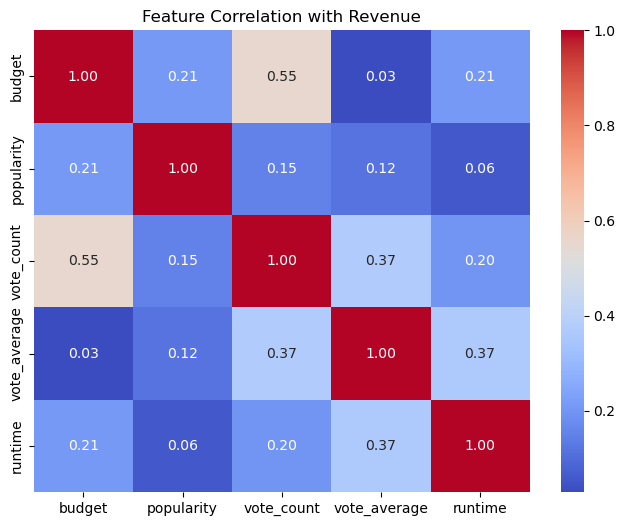

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation heatmap  
plt.figure(figsize=(8,6))
sns.heatmap(df[['budget','popularity','vote_count','vote_average','runtime']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation with Revenue")
plt.show()

##### Since there isnt high correlation, we can proceed with the first regression model. The first regression type tested was linear regression. There was high skewness in budget, popularity, and vote_count so log transform was applied to these features to improve results.  A 80/20 test split was choosen. 

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split

#Log Transform Features
X['budget_log'] = np.log1p(X['budget'])
X['popularity_log'] = np.log1p(X['popularity'])
X['vote_count_log'] = np.log1p(X['vote_count'])

# Clean feature set for modeling
X_clean = X[['vote_average', 'runtime', 'budget_log', 'popularity_log', 'vote_count_log']].copy()

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=.2, random_state=42)

##### Before initalizing and training the linear regression model we need to log transform the label. Then predict.

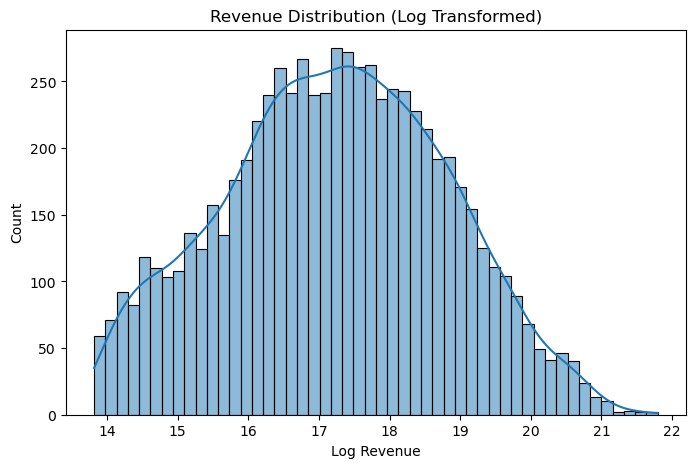

In [64]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Log-transform label
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Initialize and train Linear Regression
mod_lr = LinearRegression()
mod_lr.fit(X_train, y_train_log)

# Predict
y_pred_log = mod_lr.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Log Revenue distribution ||
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df['revenue']), bins=50, kde=True)
plt.xlabel("Log Revenue")
plt.title("Revenue Distribution (Log Transformed)")
plt.show()

## Linear Regression Model
##### The revenue is no longer highly skewed now, once the model is trained with the metrics, we can print out R2 and RMSE for the Linear Regression Model.

In [65]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log = r2_score(y_test_log, y_pred_log)

#Print Stats for 
print("Linear Regression Results:")

print("RMSE:", rmse)
print("R²:", r2)

print("Log-space RMSE:", rmse_log)
print("Log-space R²:", r2_log)

# Predictions DataFrame
predictions_df = pd.DataFrame({
    'Actual Revenue (M$)': y_test.values / 1e6,
    'Predicted Revenue (M$)': y_pred / 1e6
})

predictions_log_df = pd.DataFrame({
    'Actual Log-Revenue': y_test_log.values,
    'Predicted Log-Revenue': y_pred_log
})

print("\nPredictions (first 5 rows):")
print(predictions_df.head())
print("\nLog-space Predictions (first 5 rows):")
print(predictions_log_df.head())


Linear Regression Results:
RMSE: 126650041.62886065
R²: 0.5953066961687756
Log-space RMSE: 0.962649013610991
Log-space R²: 0.6324744994504836

Predictions (first 5 rows):
   Actual Revenue (M$)  Predicted Revenue (M$)
0           542.307423              295.063999
1            28.700000               15.675173
2           179.769467              101.667445
3             6.073724                4.370897
4           788.976453              397.361189

Log-space Predictions (first 5 rows):
   Actual Log-Revenue  Predicted Log-Revenue
0           20.111344              19.502703
1           17.172408              16.567589
2           19.007186              18.437218
3           15.619483              15.290479
4           20.486247              19.800356


##### The linear regression model explains ~60% variance in movie revenue(R2 = .5953). Revenue predictions on average were off by 126.6M, which was heavily skewed by blockbusters with high earning. However the log space showed better results with ~63% variance in movie revenue with a RMSE of ~.9626 which is 2.6x off the actual revenue (R2 = .6325).

## Analysis

##### While the model preformed moderately well, tree-based models handle skew and non-linear relationship naturally. So I went with a RFR (Random Forest Regression) model to improve the results. Since RFR models handle skew, there is no need for log transforming certain features. Now we need to train the model with the metrics. A grid searched was preformed to get the RFR paramaters.

In [66]:
from sklearn.ensemble import RandomForestRegressor

# Create a 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#Initalize RFR model
mod = RandomForestRegressor(
    n_estimators= 500,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

#Log Transform Target (Revenue)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

#Train the model
mod.fit(X_train, y_train_log)

#Predict and inverse log-transform
y_pred_rf = np.expm1(mod.predict(X_test))
y_pred_log_rf = mod.predict(X_test)

## Random Forest Regression
##### Once the model is trained we can now print the results.

In [67]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)
print("RMSE:", rmse)
print("R²:", r2)

rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log_rf))
r2_log = r2_score(y_test_log, y_pred_log_rf)
print("Log-space RMSE:", rmse_log)
print("Log-space R²:", r2_log)

predictions_df = pd.DataFrame({
    'Actual Revenue (M$)': y_test.values / 1e6,
    'Predicted Revenue (M$)': y_pred_rf / 1e6
})

predictions_log_df = pd.DataFrame({
    'Actual Log-Revenue': y_test_log.values,
    'Predicted Log-Revenue': y_pred_log_rf
})
print(predictions_log_df.head())
print(predictions_df.head())




RMSE: 105905055.99089682
R²: 0.717024567044569
Log-space RMSE: 0.9377409342589252
Log-space R²: 0.6512475350019482
   Actual Log-Revenue  Predicted Log-Revenue
0           20.111344              19.574462
1           17.172408              16.526928
2           19.007186              18.528750
3           15.619483              15.478250
4           20.486247              20.660888
   Actual Revenue (M$)  Predicted Revenue (M$)
0           542.307423              317.015843
1            28.700000               15.050599
2           179.769467              111.412539
3             6.073724                5.273740
4           788.976453              939.527614


##### The Random Forest Regression model explains ~72% variance in movie revenue(R2 = .7170). Revenue predictions on average were off by 105.9M, skewness of block busters had less of an impact due to RFR capabilaties. However the log space showed  decreased preformace with ~65% variance in movie revenue with a RMSE of ~.9377 which  is 2.55x off the actual revenue (R2 = .6512). 

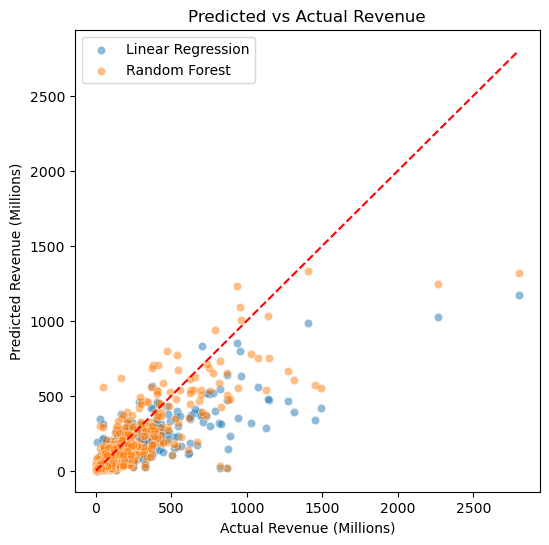

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test/1e6, y=y_pred/1e6, alpha=0.5, label="Linear Regression")
sns.scatterplot(x=y_test/1e6, y=y_pred_rf/1e6, alpha=0.5, label="Random Forest")
plt.plot([0, max(y_test/1e6)], [0, max(y_test/1e6)], color="red", linestyle="--")
plt.xlabel("Actual Revenue (Millions)")
plt.ylabel("Predicted Revenue (Millions)")
plt.title("Predicted vs Actual Revenue")
plt.legend()
plt.show()

# Conclusion
The comparison between the two regression models highlights a improvement from Linear to Random Forest. Random Forest captured non-linear relationships and reduced the ifluence of blockbusters. Which lead to higher explained variance (~72%) and smaller average prediction error(105.9M). The log space preformance was weaker which suggests it may not be the most effective representation for this dataset.

## Future Improvemnets
- Experiments with more advanced models like XGBoost or LightGBM.
- Transform label(target) with Box-Cox or Yeo-Johnson instead of log
- Combine predictions from different models using a meta-learner 